In [1]:
import numpy as np
from utils.database_repository import DataRepository
from utils.objects import *
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import time
from datetime import datetime

In [11]:
repository = DataRepository()

Connected to MySQL Server version  5.7.39-42-log


In [3]:
# CONFIGURATION
min_temp = 0
max_temp = 200

min_battery = 3
max_battery = 95

between = 2
duration = 1

language = "CSharp"

env = "PROD"

limit = 200


## OS
windows_os = "Win32NT"
linux_os = "Unix"

os = [
    windows_os,
    linux_os
    ]

## Test cases
idle_case = "TestCaseIdle"
dining_philosophers = "DiningPhilosophers"
binary_tress = "BinaryTrees"
reverse_complement = "ReverseComplement"
fannkuch_redux = "FannkuchRedux"
n_body = "Nbody"
fasta = "Fasta"

test_cases = [
    idle_case,
    dining_philosophers,
    binary_tress,
    reverse_complement,
    fannkuch_redux,
    n_body,
    fasta
]

## Profilers
intel_power_gadget = "IntelPowerGadget"
rapl = "RAPL"
hardware_monitor = "HardwareMonitor"
clamp = "Clamp"
e3 = "E3"


profilers = [
    intel_power_gadget,
    rapl,
    hardware_monitor,
    clamp,
    e3
]

## DUT
surface_pro_4 = "Surface4Pro"
surface_book = "SurfaceBook"
power_komplett = "PowerKomplett"

duts = [
    surface_pro_4,
    surface_book,
    power_komplett
]

dut_version = {
    surface_book : {
            windows_os : 4,
            linux_os : 1
        },
    surface_pro_4 : {
        windows_os : 10,
        linux_os : 1,
    },
    power_komplett : {
        windows_os : 5,
        linux_os : 1,
    }
}

In [16]:
data = {}

for d in duts:
    data[d] = {}
    for o in os:
        version = dut_version[d][o]
        data[d][version] = {}
        data[d][version][o] = {}
        for t in test_cases:
            data[d][version][o][t] = {}
            for profiler in profilers:
                data[d][version][o][t][profiler] = {}
                data[d][version][o][t][profiler]["ye"] = "yo"
                print(type(data[d][version][o][t][profiler]))
                
                
                profiler = EnergyProfiler(profiler, repository)
                config = Configuration(min_temp, max_temp, min_battery, max_battery, duration, between, version, repository, env)
                dut = Dut(d, o, repository)
                test_case = TestCase(t, repository)
                
                if config.id > 0:
                    config_id = config.id
                    dut_id = dut.id
                    test_case_id = test_case.id
                    
                    experiment = Experiment(config_id, dut_id, test_case_id, language, repository, 200)
                    
                    if len(experiment.experiments) > 0:
                        print(type(data[d][version][o][t]))
                        print("yoot")
                        # data[d][version][o][t][profiler]["config"] = config
                        data[d][version][o][t][profiler]["profiler"] = profiler
                        data[d][version][o][t][profiler]["dut"] = dut
                        data[d][version][o][t][profiler]["test_case"] = test_case
                        data[d][version][o][t][profiler]["experiment"] = experiment

data

<class 'dict'>
<class 'dict'>
yoot


KeyError: <utils.objects.EnergyProfiler object at 0x000001EDFF8154E0>

In [ ]:
energy_profiler = EnergyProfiler(profiler_name, repository)

energy_profiler.id, energy_profiler.energy_profiler_name


(1, 'IntelPowerGadget')

In [ ]:
dut = Dut(dut_name, dut_os, repository)

dut.id, dut.dut_name, dut.dut_os

(6, 'Surface4Pro', 'Win32NT')

In [ ]:
config = Configuration(min_temp, max_temp, min_battery, max_battery, duration, between, version, repository, env)

config.id, config.min_battery, config.max_battery, config.min_temp, config.max_temp, config.version, config.env, config.duration, config.between

(26, 1, 100, 0, 200, 8, 'PROD', 1, 0)

In [ ]:
test_case = TestCase(test_case_name, repository)
test_case.id, test_case.test_case_name

(3, 'IdleCase')

In [ ]:
experiment = Experiment(config.id, dut.id, test_case.id, language, repository, 200)
len(experiment.experiments), experiment.config_id, experiment.dut_id, experiment.language, experiment.test_case_id, experiment.count


(95, 26, 6, 'CSharp', 3, 200)

In [ ]:
repository.close()

In [ ]:
temp_experiment = experiment.experiments[0]

temp_experiment.end_time, temp_experiment.start_time, temp_experiment.runs, temp_experiment.iteration, temp_experiment.duration

(datetime.datetime(2022, 10, 31, 8, 24, 21, 814999),
 datetime.datetime(2022, 10, 31, 8, 23, 21, 711993),
 2,
 18,
 60041)

In [ ]:
[x.value for x in temp_experiment.start_temperature.data], [x.value for x in temp_experiment.stop_temperature.data]

([Decimal('42'), Decimal('42')], [Decimal('38'), Decimal('49')])

In [ ]:
[x.value for x in temp_experiment.start_battery.data], [x.value for x in temp_experiment.stop_battery.data]

([Decimal('4')], [Decimal('3')])

In [ ]:
durations = [x.duration / x.runs for x in experiment.experiments]
dram_avg = [x.CumulativeDramEnergyInJoules for x in experiment.experiments]
gt_power_avg = [x.CumulativeGtEnergyInJoules for x in experiment.experiments]
ai_power_avg = [x.CumulativeIaEnergyInJoules for x in experiment.experiments]
processor_power_avg = [x.CumulativeProcessorEnergyInJoules for x in experiment.experiments]

In [ ]:
dram_avg

[29497252,
 29039184,
 29114868,
 29410400,
 29326476,
 29400818,
 29311400,
 29220764,
 29227172,
 29252748,
 30076232,
 29186646,
 29179320,
 29224060,
 29928650,
 29473756,
 30609864,
 32202454,
 28795532,
 28816344,
 28759704,
 28820984,
 28776368,
 28763612,
 28782166,
 28984740,
 28803406,
 28782716,
 28746094,
 28838806,
 28816284,
 28800354,
 28772216,
 28801452,
 28793456,
 28802552,
 28818542,
 28985656,
 28785034,
 28795898,
 28850342,
 28865600,
 28839112,
 28853332,
 29859132,
 28981324,
 28904540,
 29032654,
 31082520,
 31130980,
 32570190,
 29208008,
 29243958,
 29382080,
 29437500,
 29190980,
 29204346,
 29207336,
 29231688,
 29246460,
 29256226,
 29212524,
 29182740,
 29193664,
 29493104,
 29187928,
 29399232,
 29491456,
 29543030,
 29333008,
 29240784,
 29250610,
 29317322,
 29363220,
 29221312,
 29487000,
 29311708,
 29588806,
 29637024,
 36530456,
 37093690,
 29409728,
 29247680,
 29308104,
 29346376,
 29409728,
 29370116,
 30175536,
 29405090,
 29469848,
 29553894,

In [ ]:
def add_avg_and_std(values, dict, name, i):
    dict[i]["avg_" + name] = sum(values) / len(values)  
    dict[i]["std_" + name] = np.std(values) 
    dict[i]["len_" + name] = len(values) 

In [ ]:
def plot_for_key(values_to_plot, key, y_max):
    plt.ylim(0,y_max)
    x = [v for v in values_to_plot]
    y = [values_to_plot[v]["avg_" + key] for v in values_to_plot]
    e = [values_to_plot[v]["std_" + key] for v in values_to_plot]
    
    counts = [values_to_plot[v]["len_" + key] for v in values_to_plot]
    
    print(f"The count: {counts}")

    plt.errorbar(x, y, e, linestyle='None', marker='.')

In [ ]:
groups = defaultdict(list)
values = defaultdict(dict)

for obj in experiment.experiments:
    groups[obj.iteration].append(obj)

tuples_to_plot = []

for g in groups:
    if not g in values:
        values[g] = {}
    
    durations = [x.duration / x.runs for x in groups[g]]
    dram_avg = [x.AverageDramPowerInWatt for x in groups[g]]
    gt_power_avg = [x.CumulativeGtEnergyInMwh for x in groups[g]]
    ai_power_avg = [x.AverageIaPowerInWatt for x in groups[g]]
    processor_power_avg = [x.AverageProcessorPowerWatt for x in groups[g]]
    
    # dram_avg = [x.CumulativeDramEnergyInJoules for x in groups[g]]
    # gt_power_avg = [x.CumulativeGtEnergyInJoules for x in groups[g]]
    # ai_power_avg = [x.CumulativeIaEnergyInJoules for x in groups[g]]
    # processor_power_avg = [x.CumulativeProcessorEnergyInJoules for x in groups[g]]
    
    
    add_avg_and_std(durations, values, "duration", g)
    add_avg_and_std(dram_avg, values, "dram", g)
    add_avg_and_std(gt_power_avg, values, "gt", g)
    add_avg_and_std(ai_power_avg, values, "ai", g)
    add_avg_and_std(processor_power_avg, values, "processor", g)



The count: [3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


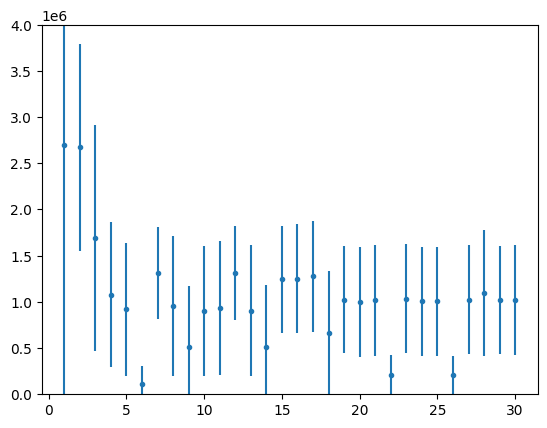

In [ ]:
plot_for_key(values, "processor", 4000000)


The count: [3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


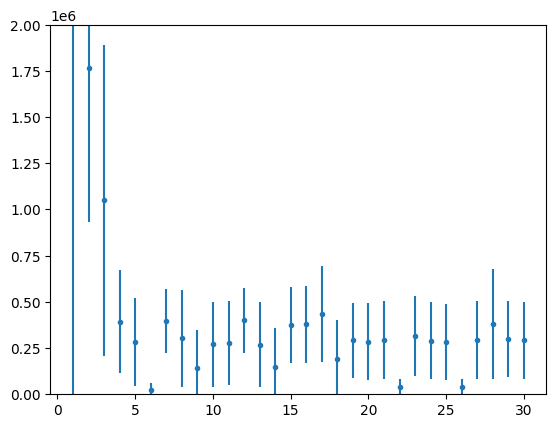

In [ ]:
plot_for_key(values, "ai", 2000000)


The count: [3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


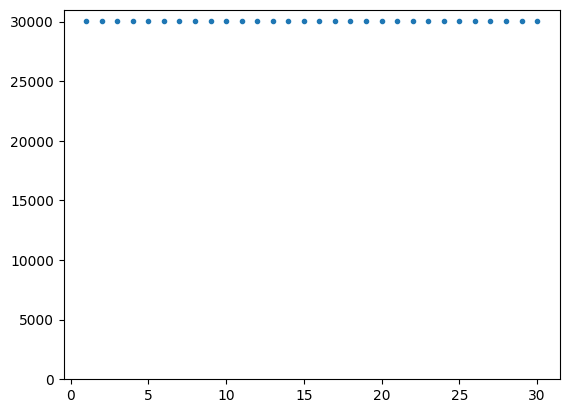

In [ ]:
plot_for_key(values, "duration", 31000)

The count: [3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


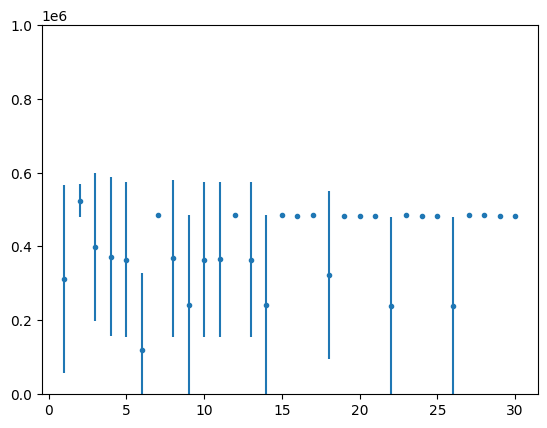

In [ ]:
plot_for_key(values, "dram", 1000000)

In [ ]:
experiment.experiments[0].time_series.data_point[0].SystemTime, experiment.experiments[0].time_series.data_point[0].PackagePL4_0Watt

('09:23:21:839', '  46.000')

In [ ]:
def get_time(data_point):
    return datetime.strptime(data_point.SystemTime, '%H:%M:%S:%f')

def get_y(data_point):
    return float(data_point.DRAMPower_0Watt.strip())

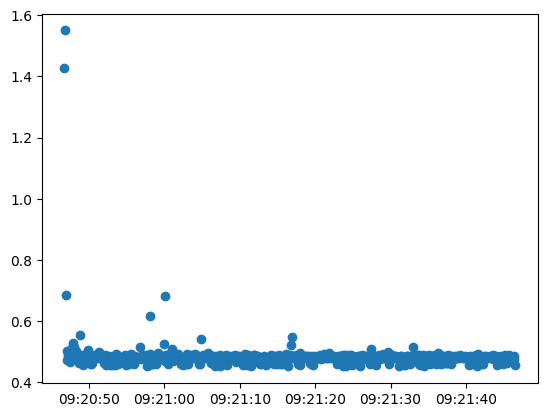

In [ ]:
index_to_plot = 2
points_to_plot = -1
experiment_to_plot = experiment.experiments[index_to_plot]

tuples_to_plot = [(get_time(x), get_y(x)) for x in experiment_to_plot.time_series.data_point[:points_to_plot]]

plt.scatter(*zip(*tuples_to_plot))

```json
{
    "SystemTime": "13:26:40:313",
    "RDTSC": " 271802431256",
    "ElapsedTimesec": "   59.225",
    "CPUUtilization": "   43.000",
    "CPUFrequency_0MHz": " 1800",
    "ProcessorPower_0Watt": "   3.571",
    "CumulativeProcessorEnergy_0Joules": " 384.071",
    "CumulativeProcessorEnergy_0mWh": " 106.686",
    "IAPower_0Watt": "   2.073",
    "CumulativeIAEnergy_0Joules": " 323.572",
    "CumulativeIAEnergy_0mWh": "  89.881",
    "PackageTemperature_0C": " 44",
    "PackageHot_0": "  0",
    "DRAMPower_0Watt": "   0.555",
    "CumulativeDRAMEnergy_0Joules": "  31.903",
    "CumulativeDRAMEnergy_0mWh": "   8.862",
    "GTPower_0Watt": "   0.003",
    "CumulativeGTEnergy_0Joules": "   0.568",
    "CumulativeGTEnergy_0mWh": "   0.158",
    "PackagePL1_0Watt": "  25.000",
    "PackagePL2_0Watt": "  25.000",
    "PackagePL4_0Watt": "  46.000",
    "PlatformPsysPL1_0Watt": "  45.000",
    "PlatformPsysPL2_0Watt": "  45.000",
    "GTFrequencyMHz": 0,
    "GTUtilization": "   0.000"
  },
```

In [ ]:
class Bucket(object):
    def __init__(self, min_value, max_value):
        self.min = min_value
        self.min = min_value
        self.max = 

In [ ]:
# [x.value for x in temp_experiment.battery.data]
min_bucket = 0
max_bucket = 100
bucket_size = 5

last_value = 0

for i in range(min_bucket + bucket_size, max_bucket + 1, bucket_size):
    print(f"min: {last_value}, max: {i}, between: {((i - last_value) / 2) + last_value}")
    last_value = i



min: 0, max: 5, between: 2.5
min: 5, max: 10, between: 7.5
min: 10, max: 15, between: 12.5
min: 15, max: 20, between: 17.5
min: 20, max: 25, between: 22.5
min: 25, max: 30, between: 27.5
min: 30, max: 35, between: 32.5
min: 35, max: 40, between: 37.5
min: 40, max: 45, between: 42.5
min: 45, max: 50, between: 47.5
min: 50, max: 55, between: 52.5
min: 55, max: 60, between: 57.5
min: 60, max: 65, between: 62.5
min: 65, max: 70, between: 67.5
min: 70, max: 75, between: 72.5
min: 75, max: 80, between: 77.5
min: 80, max: 85, between: 82.5
min: 85, max: 90, between: 87.5
min: 90, max: 95, between: 92.5
min: 95, max: 100, between: 97.5
